# <font color=orange> Final Exam : Amazon reviews on "Fire tablet" products </font>

#### <font color=blue> product specification: Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta </font>

## <font color=Green> Student Name: PUJA KAWALE </font>

## <font color=Green> SJSU ID: 012506156 </font>

#### The scope of the project is to explore the reviews submitted by users and understand deeply about the recommendations

#### The notebook answers the following questions:

1. Understand and clean the data

    Check for null values
    Drop columns which aren't useful
    
2. Speculate whether ratings are genuine ?

    what if the one user is trying to give all rating ?
    How will the distribution look for bulk users ?
    How many users are bulk ?
    
3. Find the NPS net promoter score of amazon

    What's NPS score ?
    How do we calculated for amazon  ?
    
4. Pick a product and deep dive

    We will pick one variation of kindle product drill & analyze its characteristics
    
5. [Choose a Product] - What is the NPS score  ? 

6. [Choose a Product] - Plot time series for review

      How to handle date time text ?
      How to plot time series on a graph ? 
      How does the graph look like in small intervals of 7 days or 14 days or 30 days ?
       
      Did the performance (NPS) go up or down with time ?
     
7. [Choose a Product] Predict Recommendations based on reviews content

    Make a clean function
    Remove punctuations
    Remove stop-words
    Stem and Lemmatize
    Create a Distillation of the comments
        Identify Features 
        Create a TFIDF vectorizer, or other Word Embeddings
        Understand and explore sentiment analysis
        Use compound feature
        Apply LDA to identify Topics
    Use RandomForestClassifier at minimum, but are free to use other classifiers in addition to RF
    Check the score in multiple ways
    
 <br>       
        
<font color=blue> Extra innings: </font>
 
<font color=blue> - Developed and compared 5 different Classifiers on the TFIDF vectors </font> <br>
<font color=blue> - Count Vectorizer and tested for Random forest model </font> <br>
<font color=blue> - Compared LDA using BOW and TFIDF and checked performance </font> <br>

# 1. Understand and clean the data

- Check for null values
- Drop columns which arent useful


In [31]:
import pandas as pd
import numpy as np

In [32]:
rev = pd.read_csv('1429_1.csv')
rev.columns = ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer','date', 'dateAdded', 'dateSeen',
       'didPurchase', 'doRecommend', 'id','numHelpful', 'rating', 'sourceURLs','text', 'title', 'userCity',
       'userProvince', 'username']

C:\Users\PB\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
rev.nunique()

id                 42
name               48
asins              41
brand               6
categories         41
keys               42
manufacturer        2
date             1078
dateAdded        1941
dateSeen         3911
didPurchase         1
doRecommend         2
id                  1
numHelpful         97
rating              5
sourceURLs      11929
text            34659
title           19767
userCity            0
userProvince        0
username        26789
dtype: int64

There are lot of null values and irrelevant columns 

In [34]:
rev.isnull().sum()
#lets drop usernames, userProvince,id,didPurchase

id                  0
name             6760
asins               2
brand               0
categories          0
keys                0
manufacturer        0
date               39
dateAdded       10621
dateSeen            0
didPurchase     34659
doRecommend       594
id              34659
numHelpful        529
rating             33
sourceURLs          0
text                1
title               5
userCity        34660
userProvince    34660
username            2
dtype: int64

In [35]:
rev.drop(labels=['didPurchase','id','userCity','userProvince'],axis=1,inplace=True)

In [36]:
rev.isnull().sum()

name             6760
asins               2
brand               0
categories          0
keys                0
manufacturer        0
date               39
dateAdded       10621
dateSeen            0
doRecommend       594
numHelpful        529
rating             33
sourceURLs          0
text                1
title               5
username            2
dtype: int64

# 2. Lets see which reviews are genuine.

To check : 
- One user is trying to give all rating, its should not be the case.
- the distribution for bulk users 
- Number of Bulk users

### Are the all the reviews given by same group of users ? 

Total ratings : 34658
Total users : 26789
Users giving bulk ratings (more than 10) : 146
Bulk ratings : 3160
Populations of bulk ratings : 9.117664031392463
Populations of bulk users : 0.5449998133562283


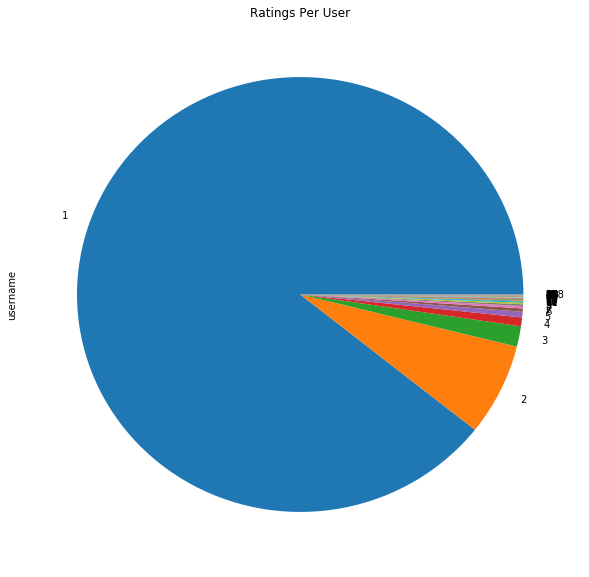

In [37]:
rate_perperson=rev.username.value_counts()
# print(rating_perperson.value_counts())
print ("Total ratings : " + str(sum(rate_perperson)))
print ("Total users : " + str(len(rate_perperson)))
print("Users giving bulk ratings (more than 10) : " + str(sum(rate_perperson >10)))
bulk = rate_perperson[rate_perperson >10]
bulk_rating = sum(bulk)
print ("Bulk ratings : " + str(bulk_rating))
print ("Populations of bulk ratings : " + str(bulk_rating*100/sum(rate_perperson)))
print ("Populations of bulk users : " + str(sum(rate_perperson >10)*100/len(rate_perperson)))
rate_perperson.value_counts().plot(kind='pie',figsize=(10,10), title='Ratings Per User')

#### Pie chart reveals  most of the users have given single rating but,
 #### 1 : Only 0.55 % of the users are bulk users
 #### 2 : Around 9 % of the ratings have been submitted by just 0.55% users - Does it seem odd to you ?

count    3158.000000
mean        4.593414
std         0.732940
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64
count    31469.000000
mean         4.583686
std          0.735930
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


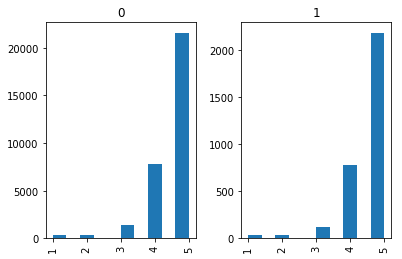

In [39]:
rev['bulk']= rev['username'].apply(lambda x : 1 if x in bulk.index else 0)
#gives us the category whether a rating is bulk or not
from matplotlib import pyplot
#series.hist(by=series)
print(rev.rating.hist(by=rev.bulk))
print(rev[rev.bulk==1].rating.describe())
print(rev[rev.bulk==0].rating.describe())


### As above plot shows, bulk users have the same rating distribution as others, hence theay are not fraud users.

### Distribution of User rating

*** Rating distribution ***
5.0    23775
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: rating, dtype: int64


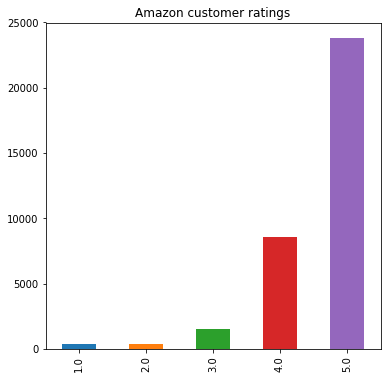

In [40]:
from matplotlib import pyplot
%matplotlib inline

star = rev.rating.value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

# 3. Find the NPS net promoter score of amazon
- What's NPS score ?
- How do we calculated for amazon  ?

# NPS Score ( Net promoter score ) 

In [41]:
star.loc[5]
print(star.loc[5])
print(sum(star.loc[:]),2)
star.head()
NPS_score = round (100*((star.loc[5])-sum(star.loc[1:3]))/sum(star.loc[:]),8)
print(NPS_score)

23775
34627 2
61.98631126


#### Net Promoters Score helps us evaluate customer satisfaction and loyalty

Rating 1,2,3 - Detractors <br>
Rating 4   - Passive <br>
Rating 5 - Promoters <br>

NPS = (Promoters - Detractors)/Total ratings * 100

In [42]:
NPS_score = round (100*((star.loc[5])-sum(star.loc[1:3]))/sum(star.loc[:]),2)
print (" NPS score of Amazon is : "  + str(NPS_score))


 NPS score of Amazon is : 61.99


### NPS score of Amazon is : 61.99

# 4. Pick a product and deep dive
- We will pick one variation of Fire tablet, drill & analyse its characteristics

Lets deep dive to analyse - Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta

In [43]:
firetablet = rev[rev.name=='Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta']

In [44]:
firetablet.isnull().sum()
# The dataset looks good to go

name              0
asins             0
brand             0
categories        0
keys              0
manufacturer      0
date              0
dateAdded       215
dateSeen          0
doRecommend       4
numHelpful        4
rating            4
sourceURLs        0
text              0
title             0
username          1
bulk              0
dtype: int64

# 5. [Fire Tablet] - NPS score  ? 

 NPS score of Fire Tablet is : 49.79


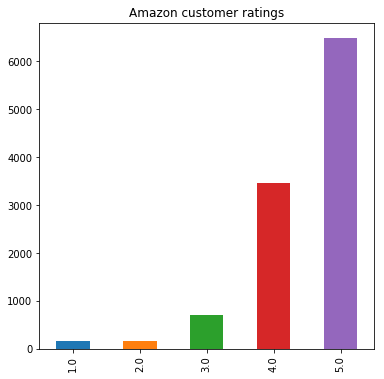

In [45]:
firetablet_s = firetablet.rating.value_counts()
firetablet_s.sort_index(inplace=True)

firetablet_NPS_score = round (100*(firetablet_s[5]-sum(firetablet_s[1:3]))/sum(firetablet_s),2)
print (" NPS score of Fire Tablet is : "  + str(firetablet_NPS_score))
#better NPS than overall amazon
firetablet_s.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

### What about recommendations ? How is rating related to recommendation ?

In [46]:
firetablet.doRecommend.value_counts()

True     10420
False      542
Name: doRecommend, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000008180FD0>,
      dtype=object)

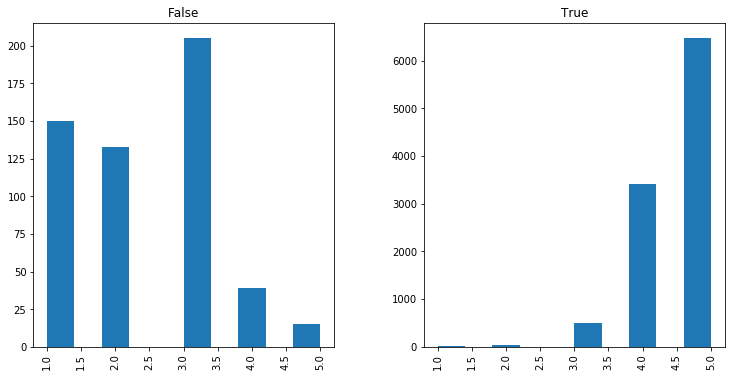

In [47]:
firetablet.rating.hist(by=firetablet.doRecommend,figsize=(12,6))

In [48]:
plus_firetablet = firetablet[firetablet.doRecommend==True].rating.value_counts()
plus_firetablet.sort_index(inplace=True)
recomm_NPS = round(100*(sum(plus_firetablet[4:5])-sum(plus_firetablet[1:2]))/sum(plus_firetablet),2)
minus_firetablet = firetablet[firetablet.doRecommend==False].rating.value_counts()
minus_firetablet.sort_index(inplace=True)
notrecomm_NPS = round(100*(sum(minus_firetablet[4:5])-sum(minus_firetablet[1:2]))/sum(minus_firetablet),2)
print("Those who recommend amazon firetablet generate high NPS score of " + str(recomm_NPS))
print("Those who DO NOT recommend firetablet produce a NPS score of " + str(notrecomm_NPS))
print(" ~ pretty much correct definition of NPS score")


Those who recommend amazon firetablet generate high NPS score of 94.44
Those who DO NOT recommend firetablet produce a NPS score of -42.25
 ~ pretty much correct definition of NPS score


# 6. [Fire Tablet] - Plot time series for reviews 
- How to handle date time text ?
- How to plot time series on a graph ? 
- How does the graph look like in small intervals of 5 days or 10 days or 30 days ?
- Did the performance (NPS) go up or down with time ?


C:\Users\PB\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,name,asins,brand,categories,keys,manufacturer,date,dateAdded,dateSeen,doRecommend,numHelpful,rating,sourceURLs,text,title,username,bulk,span
3480,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B00ZV9PXP2,Amazon,"Electronics,iPad & Tablets,All Tablets,Compute...",allnewkindleereaderblack6glarefreetouchscreend...,Amazon,2017-10-07T00:00:00.000Z,NaN,2017-10-10T00:00:00Z,True,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,The sales people are really nice and knowledge...,Great product,richard,0,2017-10-07
3481,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B00ZV9PXP2,Amazon,"Electronics,iPad & Tablets,All Tablets,Compute...",allnewkindleereaderblack6glarefreetouchscreend...,Amazon,2017-10-07T00:00:00.000Z,NaN,2017-10-10T00:00:00Z,True,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,Great product and service and the sales man r ...,Great product,richard,0,2017-10-07
3482,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B00ZV9PXP2,Amazon,"Electronics,iPad & Tablets,All Tablets,Compute...",allnewkindleereaderblack6glarefreetouchscreend...,Amazon,2017-10-07T00:00:00.000Z,NaN,2017-10-10T00:00:00Z,True,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,Great product and service will refer to a frie...,Great product and service,richard,0,2017-10-07
3483,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B00ZV9PXP2,Amazon,"Electronics,iPad & Tablets,All Tablets,Compute...",allnewkindleereaderblack6glarefreetouchscreend...,Amazon,2017-10-06T00:00:00.000Z,NaN,2017-10-10T00:00:00Z,True,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,very good product and service will refer a fri...,very good product and service.,Richard,1,2017-10-06
3484,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",B00ZV9PXP2,Amazon,"Electronics,iPad & Tablets,All Tablets,Compute...",allnewkindleereaderblack6glarefreetouchscreend...,Amazon,2017-09-30T00:00:00.000Z,NaN,2017-10-10T00:00:00Z,True,0.0,5.0,http://reviews.bestbuy.com/3545/5442403/review...,Great selections. Hard to find assistance at t...,Good selection.,Scheu,0,2017-09-30


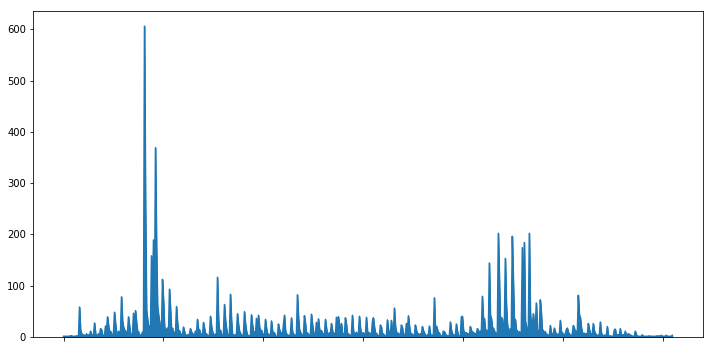

In [49]:
firetablet['span'] = firetablet.date.apply(lambda x : pd.to_datetime(x))
firetablet_review_dates = firetablet.date.value_counts()
# print(firetablet.date.value_counts())
firetablet_review_dates.sort_index(inplace=True)
firetablet_review_dates.plot(kind='area',figsize=(12,6))
firetablet.head(5)

In [50]:
rating_perdate = firetablet_review_dates.sort_values(ascending=False)
peakrating = rating_perdate[:20]
peak_month=[]
for x in peakrating.index:
    peak_month.append(pd.to_datetime(x).month)
pd.Series(peak_month).value_counts()

1     11
12     6
3      2
6      1
dtype: int64

#### Insight 
1. January month has the highest number of peaks >> Activity is high >> More Sales during Jan ( We all know)
2. There is high degree of variance in reviews added over time



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009D11550>]],
      dtype=object)

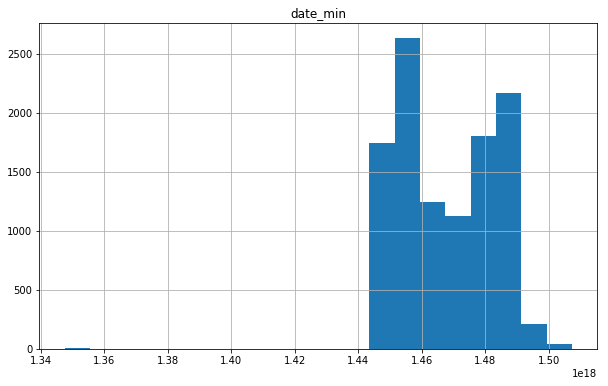

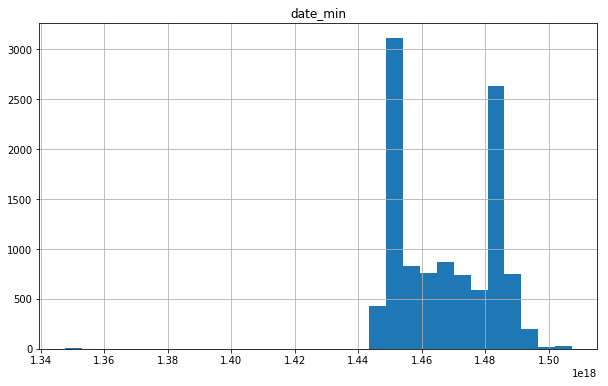

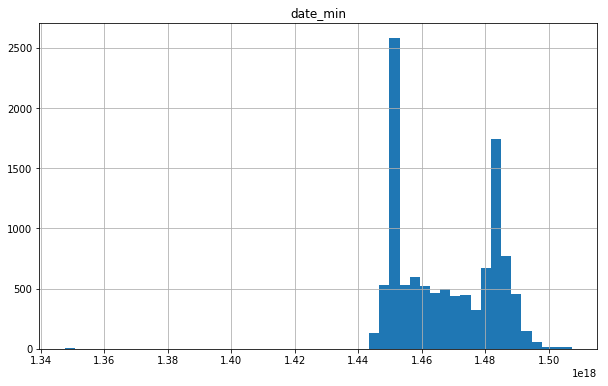

In [51]:
rating_series = pd.DataFrame(firetablet.date)
dforms=[]
for x in rating_series.date:
    dforms.append((pd.to_datetime(x)).value)
# now we have dforms which has dates transformed to numeric values
rating2 = rating_series.assign(date_min = dforms)
# print(rating2)
rating2.reset_index(inplace=True)
#rating2.set_index('date_min')
#rating2.columns=['timestamp_string','review_count','date_min']
bins = np.linspace(min(rating2.date_min),max(rating2.date_min),num=50)
rating2.hist(column='date_min', bins=20,figsize=(10,6),)
rating2.hist(column='date_min', bins=30,figsize=(10,6))
rating2.hist(column='date_min', bins=50,figsize=(10,6))


In [52]:
def NPS_eval (A):
    score =0
    for x in A[:]:
        if (x>4) :
            score+=1
        elif (x<4) :
            score-=1
    return 100*score/len(A)    

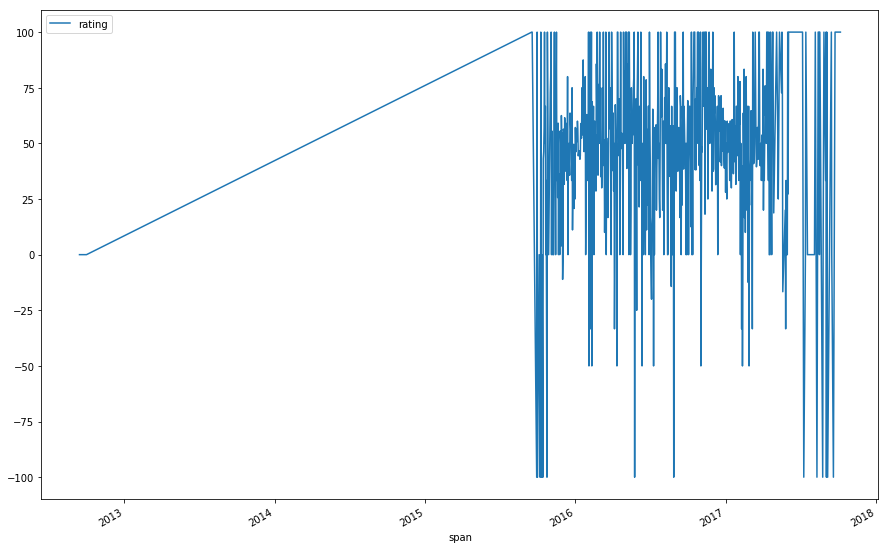

In [53]:
NPS_overtime = firetablet[['span','rating']]
NPS_overtime.groupby(by='span').agg(NPS_eval).plot(figsize=(15,10))


AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\PB\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,rating
timeline,
-27,0.000000
-26,0.000000
31,25.000000
9,33.333333
32,33.333333
33,35.714286
10,37.500000
29,39.130435
11,41.509434


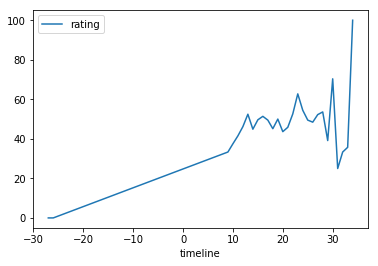

In [54]:
NPS_overtime['timeline']= NPS_overtime['span'].apply(lambda x : (x.month+(12*(x.year-2015))))
NPS_by_month= NPS_overtime.groupby(by='timeline').agg(NPS_eval)
print(NPS_by_month.plot())
NPS_by_month.sort_values(by='rating')

# 7. [Fire Tablet] Predict Recommendations based on reviews content

    Make a clean function
    Remove punctuations
    Remove stop-words
    Stem and Lemmatize
    Create a Distillation of the comments
        Identify Features 
        Create a TFIDF vectorizer, or other Word Embeddings
        Understand and explore sentiment analysis
        Use compound feature
        Apply LDA to identify Topics
    Use RandomForestClassifier at minimum, but are free to use other classifiers in addition to RF
    Check the score in multiple ways

## Let us predict recommendations with given comments on product

In [55]:
comments = pd.concat([firetablet['text']+". "+ firetablet['title'],firetablet['rating'],firetablet['doRecommend']],axis=1)
comments.head()
comments.columns=['text','rating','recommend']

## Cleaning Function:

Remove punctuations <br>
Remove stop-words <br>
Stem and Lemmatize <br>


In [56]:
import string
import nltk
from nltk import PorterStemmer
import re 

stopwords = nltk.corpus.stopwords.words('english')
ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()


def clean_stem (sent): 
    temp1 ="".join(x for x in sent if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3

def clean_lemma (sent): 
    temp1 ="".join(x for x in sent if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
    return temp3

text="Hello this is, my happiest place. organize, organizes, and organizing in Happy world ! with happiness ..\
so much of happy!! "

print("Stemmed " + "-".join(clean_stem(text)))
print("Lemmatized " + "-".join(clean_lemma(text)))

Stemmed hello-happiest-place-organ-organ-organ-happi-world-happi-much-happi-
Lemmatized hello-happiest-place-organize-organizes-organizing-happy-world-happiness-much-happy-


## Creating vectors from the text columns - TFIDF Vectorization

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectstem = TfidfVectorizer(analyzer=clean_stem)
vectlemm = TfidfVectorizer(analyzer=clean_lemma)

textfeat=vectstem.fit_transform(comments['text'])
print("Stemmed - " + str(len(vectstem.get_feature_names())))

vectlemm.fit_transform(comments['text'])
print("Lemmatized - " + str(len(vectlemm.get_feature_names())))


Stemmed - 6558
Lemmatized - 7981


Stemmed has features 18 % lower than that of Lemmatized. 
    - In the above example in happy line, you can see how ineffective lemmatization can be 
    - Thus we will be applying cleanstem algo here
    - Lower features means more information density in the compressed columns

### Lets have a look on our stemmed data

In [58]:
pd.DataFrame(textfeat.toarray()).head(15)

,0,1,2,3,4,5,6,7,8,9,...,6548,6549,6550,6551,6552,6553,6554,6555,6556,6557
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The column names dont make sense - Need to update them with real words
    - for this we use vectstem.vocabulary_ to modify the columns

In [59]:
textmatrix = pd.DataFrame(textfeat.toarray(),columns=vectstem.vocabulary_)
textmatrix.head(5)

,sale,peopl,realli,nice,knowledg,come,back,great,product,servic,...,paw,on,rad,strang,naviag,fore,windowsbas,lockeddown,outclass,facial
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
sum_scores = pd.DataFrame(textmatrix.sum(),columns=['sum_scores_TFIDF'])
sum_scores

,sum_scores_TFIDF
sale,25.292907
peopl,1.212420
realli,0.522939
nice,19.744640
knowledg,33.604901
come,9.997087
back,1.863261
great,0.583728
product,0.112094
servic,1.244032


In [61]:
# Need to see most important words in the reviews
# words used by many people or less frequent in sentences
sum_scores.sort_values(by='sum_scores_TFIDF',ascending=True)[:5] 

,sum_scores_TFIDF
leagu,0.060883
perchu,0.060883
autoansw,0.060883
expectedexcel,0.060883
detest,0.060883


In [62]:
#high usage of words in reviews
sum_scores.sort_values(by='sum_scores_TFIDF',ascending=False)[:5]

,sum_scores_TFIDF
mircosd,914.630993
stash,888.899627
aidiobook,547.927548
welli,525.789542
33,497.725612


### Lets build features on our data


In [63]:
pd.set_option('display.max_colwidth', 0)
comments.head()

,text,rating,recommend
3480,The sales people are really nice and knowledgeable to me I will come back again. Great product,5.0,True
3481,Great product and service and the sales man r really nice.. Great product,5.0,True
3482,Great product and service will refer to a friend. And the sales man r good. Great product and service,5.0,True
3483,very good product and service will refer a friend.. very good product and service.,5.0,True
3484,Great selections. Hard to find assistance at times.. Good selection.,5.0,True


## Sentiment Analysis

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

happy = "I am Happy. this is so awesome. I love life. I will be in heaven"
#when you find free food in university
print("happy " + str(sid.polarity_scores(text)))


sad = "i hate this. I am mad this is stupid. I will kill you"
#when your professor gives you a ZERO in assignment
print("sad " + str(sid.polarity_scores(sad)))

neut = "I will come. You should go. This is blue color"
#when you state facts and nothing else
print("neutral " + str(sid.polarity_scores(neut)))

seed = "money"
print("dss " + str(sid.polarity_scores(seed)))


happy {'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'compound': 0.9522}
sad {'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'compound': -0.9432}
neutral {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
dss {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


C:\Users\PB\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#### Understand the output
    - sid.polarity is a dictionary
    - pos and neg indicates - positive and negative emotions in sentence
    - we should be interested in compound score which calculates the final effect
   

In [65]:
# Feature 1 : Sentiment compound value
def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']
    
#sentiment(happy)
comments['sentiment']= comments['text'].apply(lambda x : sentiment(x))

In [66]:
# Feature 2 : Length of string

comments['length'] = comments['text'].apply(lambda x : len(re.split('\W+',x)))
comments[comments['rating']==5].head(10)

# converting all true >> 1 and false as 0
def convert(x):
    
    if x==True:
        return 1
    else :
        return 0
    
print(convert("False"))

comments['target_rec'] = comments['recommend'].apply(lambda x : convert(x))
comments.head(5)

0


,text,rating,recommend,sentiment,length,target_rec
3480,The sales people are really nice and knowledgeable to me I will come back again. Great product,5.0,True,0.8016,17,1
3481,Great product and service and the sales man r really nice.. Great product,5.0,True,0.8481,13,1
3482,Great product and service will refer to a friend. And the sales man r good. Great product and service,5.0,True,0.9360,19,1
3483,very good product and service will refer a friend.. very good product and service.,5.0,True,0.7496,15,1
3484,Great selections. Hard to find assistance at times.. Good selection.,5.0,True,0.7650,11,1


In [67]:
comments[comments['rating']==1].head(5)

,text,rating,recommend,sentiment,length,target_rec
3544,Am used to Kindle Fire which I love. No light to read by in the dark. Hard to navigate. This was a gift - would never purchase on my own.. HATE IT!!!!!,1.0,False,-0.5425,32,0
3824,This device is OK for reading or listening to audiobooks via Overdrive app. Wouldn't recommend it though really. Waited to buy Kindle for years. Would suggest doing research before buying this device.. Extremely slow,1.0,False,0.2079,35,0
3853,Not Kid friendly at all. Purchased for little nephew. Wasn't given any info on it for sales person either. Took back!!!. Terrible,1.0,False,-0.7652,23,0
3855,Screen was cracked but the package did arrive earlier than expected. Arrived broken,1.0,False,-0.6310,13,0
3900,Purchased two of these tablets. Both of them had 4-7 dead pixels all over the screen. Read a lot of online reviews which stated same problem. The screen/resolution is pretty bad but what can you expect for $50.. Ok tablet I must have got 2 bad ones,1.0,False,-0.7650,49,0


### Recommendation Prediction: 

In [71]:
#Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

# need to reset index of the comments column to match with textfeatures
new_sentiment = comments.sentiment.reset_index()['sentiment']
new_length = comments.length.reset_index()['length']

x_feat = pd.concat([new_sentiment,new_length,pd.DataFrame(textfeat.toarray(),columns=vectstem.vocabulary_)],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_feat,comments.target_rec,test_size=0.2)

rf = RandomForestClassifier(n_jobs=-1,n_estimators=50,max_depth=90)
rfmodel=rf.fit(x_train,y_train)

y_pred = rfmodel.predict(x_test)
sorted(zip(rfmodel.feature_importances_,x_train.columns),reverse=True)[0:10]
# print(x_features)


[(0.0662064989231416, 'sentiment'),
 (0.019553723512815913, 'vision'),
 (0.016538361539289146, 'ose'),
 (0.013756259891681307, 'killer'),
 (0.013644599554783832, 'length'),
 (0.013359009431348592, 'stash'),
 (0.009335612231855072, 'mircosd'),
 (0.008315219686159692, 'darn'),
 (0.007975239523216637, 'alright'),
 (0.007695272125139632, 'incas')]

In [72]:
precision, recall, fscore , support = score(y_test,y_pred,average='binary')
print('Precision: {} / Recall :{} / Accuracy {} '.format(round(precision,3),
                                                         round(recall,3),
                                                         round((y_pred==y_test).sum()/len(y_test),3)))

print ("Score:", rf.score(x_test, y_test))

Precision: 0.953 / Recall :1.0 / Accuracy 0.953 
Score: 0.9530537830446673


In [73]:
#Logistic regression classifier

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn import linear_model

lm = linear_model.LogisticRegression(verbose=1)
model = lm.fit(x_train, y_train)
pred = lm.predict(x_test)

print ("Score:", lm.score(x_test, y_test))
print(metrics.classification_report(y_test,pred))

[LibLinear]Score: 0.955788514129444
             precision    recall  f1-score   support

          0       0.59      0.27      0.37       106
          1       0.96      0.99      0.98      2088

avg / total       0.95      0.96      0.95      2194



In [74]:
#Decision Tree classifier

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(x_train, y_train)
dec_pred = clf_gini.predict(x_test)
print ("Score:", clf_gini.score(x_test, y_test))

print(metrics.classification_report(y_test,dec_pred))

Score: 0.95077484047402
             precision    recall  f1-score   support

          0       0.47      0.13      0.21       106
          1       0.96      0.99      0.97      2088

avg / total       0.93      0.95      0.94      2194



In [75]:
# Gaussian Naive Bayes

import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)

print ("Score:", gnb.score(x_test, y_test))
print(metrics.classification_report(y_test,gnb_pred))

Score: 0.4995442114858706
             precision    recall  f1-score   support

          0       0.05      0.47      0.08       106
          1       0.95      0.50      0.66      2088

avg / total       0.91      0.50      0.63      2194



In [77]:
#Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
num_trees=200

ranf=RandomForestClassifier(n_estimators=num_trees)
ranf.fit(x_train, y_train)
ranf_pred=rf.predict(x_test)

print ("Score:", ranf.score(x_test, y_test))
print(metrics.classification_report(y_test,ranf_pred))

Score: 0.9521422060164084
             precision    recall  f1-score   support

          0       0.80      0.04      0.07       106
          1       0.95      1.00      0.98      2088

avg / total       0.95      0.95      0.93      2194



In [78]:
# #Support Vector Classifier - taked too long and creates load on the kernel 

# from sklearn.svm import SVC
# from sklearn.svm import LinearSVC
# import pickle

# modelSVC = LinearSVC()
# modelSVC.fit(x_train, y_train)
# svc_pred = modelSVC.predict(x_test)
# s = pickle.dumps(modelSVC)

# classifier_conf = SVC(kernel='linear', probability=True)
# classifier_conf.fit(x_train, y_train)

# from sklearn.metrics import accuracy_score, f1_score

# print('Testing accuracy %s' % accuracy_score(y_test, svc_pred))
# print('Testing F1 score: {}'.format(f1_score(y_test, svc_pred, average='weighted')))

In [79]:
#K-Nearest Neighbour

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)

knn_scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the knn classifier with 10 fold cross-validation is ' + str(knn_scores.mean()))

print(knn_scores)

knn_cv_mean = np.mean(knn_scores)
knn_cv_variance = np.var(knn_scores)

print('Knn Mean score : ', knn_cv_mean)
print('Knn Score variance : ', knn_cv_variance)

The accuracy of the knn classifier with 10 fold cross-validation is 0.9500687007633706
[0.94646925 0.95102506 0.94754846 0.95210946 0.95210946 0.94982896
 0.94754846 0.95553022 0.94868871 0.94982896]
Knn Mean score :  0.9500687007633706
Knn Score variance :  6.675080050632549e-06


### From above, comparing the score of classifiers used in this notebook on tfifd vectors : 
    
Random forest: 0.9530537830446673
K-Nearest Neighbors: 0.9500687007633706
Logistic Regression: Score: 0.955788514129444
Decision tree: 0.95077484047402
Gaussian Naive Bayes: 0.4995442114858706

#### <font color=green> I conclude that best performing model is - <font color=blue>Logistic Regression with the accuracy score of 0.955788514129444 </font>

    

## Count Vectorizer

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

# Transforms the data into a bag of words
count_train = count_vec.fit(comments['text'])
bag_of_words = count_vec.transform(comments['text'])

In [81]:
# Print the first 10 features of the count_vec

print("Every feature:\n{}".format(count_vec.get_feature_names()))
print("\nEvery 3rd feature:\n{}".format(count_vec.get_feature_names()[::3]))

Every feature:
['00', '000', '0ne', '10', '100', '1000', '1000s', '100s', '1024', '1024x600', '107', '1080', '1080p', '10k', '10x', '10yr', '11', '12', '120', '125', '128', '128gb', '12hr', '12th', '12yr', '13', '13yrs', '14', '140', '149', '14yr', '15', '150', '159', '15yr', '15yrs', '16', '16g', '16gb', '16love', '16th', '16yr', '17', '17th', '18', '185', '19', '194', '1each', '1for', '1m', '1st', '1thing', '1wasnt', '20', '200', '200gb', '2011', '2012', '2013', '2014', '2015', '2016', '20x', '21', '21st', '22', '225', '24', '25', '250', '26', '27', '270', '29', '2gb', '2nd', '2s', '2y', '2year', '2yo', '2yr', '30', '300', '3000', '30day', '32', '32g', '32gb', '32gig', '33', '34', '35', '36', '37', '38', '39', '3d', '3ds', '3dvd', '3gave', '3m', '3rd', '3s', '3t', '3x', '3yr', '40', '400', '42', '45', '450', '48', '49', '4gb', '4k', '4more', '4out', '4stars', '4th', '4x', '4y', '4yo', '4yr', '50', '500', '500572304', '512mb', '52', '53', '54', '55', '58', '59', '5g', '5ghz', '5h', '5

In [82]:
print("Vocabulary size: {}".format(len(count_train.vocabulary_)))
print("Vocabulary content:\n {}".format(count_train.vocabulary_))

Vocabulary size: 7088
Vocabulary content:
 {'sales': 5411, 'people': 4539, 'really': 5044, 'nice': 4182, 'knowledgeable': 3547, 'come': 1334, 'great': 2874, 'product': 4853, 'service': 5565, 'man': 3837, 'refer': 5119, 'friend': 2633, 'good': 2781, 'selections': 5527, 'hard': 2969, 'assistance': 608, 'times': 6396, 'selection': 5525, 'kindle': 3522, 'basic': 732, 'easy': 2054, 'use': 6689, 'ereader': 2193, 'exactly': 2239, 'wanted': 6829, 'charge': 1184, 'lasts': 3595, 'long': 3753, 'time': 6390, 'don': 1950, 'worry': 6999, 'charging': 1190, 'daily': 1657, 'disappointed': 1870, 'realize': 5041, 'light': 3668, 'night': 4193, 'reading': 5030, 'size': 5709, 'weight': 6892, 'affordable': 364, 'increased': 3237, 'storage': 5995, 'backlight': 691, 'screen': 5474, 'better': 818, 'ok': 4304, 'strong': 6028, 'quality': 4959, 'thought': 6352, 'big': 828, 'small': 5766, 'paper': 4469, 'turn': 6546, 'just': 3463, 'like': 3679, 'palm': 4460, 'think': 6340, 'read': 5023, 'comfortable': 1337, 'regula

# N-grams (sets of consecutive words)
* N=2

In [83]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None)

count_train = count_vec.fit(comments['text'])
bag_of_words = count_vec.transform(comments['text'])

print(count_vec.get_feature_names())

['00', '00 85', '00 8in', '00 battery', '00 best', '00 bfs', '00 black', '00 bought', '00 broken', '00 buy', '00 credit', '00 decent', '00 does', '00 dollars', '00 gift', '00 good', '00 great', '00 kindle', '00 little', '00 loved', '00 month', '00 nice', '00 price', '00 regular', '00 remove', '00 sale', '00 saved', '00 say', '00 stay', '00 steal', '00 surf', '00 surprise', '00 tablet', '00 thing', '00 vacuum', '00 wont', '00 worth', '00 year', '000', '000 mile', '0ne', '0ne rally', '10', '10 00', '10 10', '10 11', '10 12', '10 15', '10 18', '10 2012', '10 amazing', '10 apps', '10 best', '10 books', '10 buying', '10 card', '10 cases', '10 christmas', '10 device', '10 did', '10 downloads', '10 experience', '10 fold', '10 gameplay', '10 gave', '10 gifting', '10 glad', '10 good', '10 great', '10 hours', '10 husband', '10 inch', '10 ios', '10 ipad', '10 just', '10 kindle', '10 laptop', '10 lenovo', '10 link', '10 love', '10 loved', '10 loves', '10 micro', '10 minutes', '10 month', '10 month

* N=3

In [84]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 3), max_df=1.0, min_df=1, max_features=None)

count_train = count_vec.fit(comments['text'])
bag_of_words = count_vec.transform(comments['text'])

# print(count_vec.get_feature_names())

# Min_df

Min_df ignores terms that have a document frequency (presence in % of documents) strictly lower than the given threshold. For example, Min_df=0.66 requires that a term appear in 66% of the docuemnts for it to be considered part of the vocabulary.
Sometimes min_df is used to limit the vocabulary size, so it learns only those terms that appear in at least 10%, 20%, etc. of the documents.

In [85]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=0.50, min_df=1, max_features=None)

count_train = count_vec.fit(comments['text'])
bag_of_words = count_vec.transform(comments['text'])

print(count_vec.get_feature_names())
print("\nOnly 'park' is ignored because it appears in 2 out of 3 documents, meaning 0.66% of the time.")

['00', '000', '0ne', '10', '100', '1000', '1000s', '100s', '1024', '1024x600', '107', '1080', '1080p', '10k', '10x', '10yr', '11', '12', '120', '125', '128', '128gb', '12hr', '12th', '12yr', '13', '13yrs', '14', '140', '149', '14yr', '15', '150', '159', '15yr', '15yrs', '16', '16g', '16gb', '16love', '16th', '16yr', '17', '17th', '18', '185', '19', '194', '1each', '1for', '1m', '1st', '1thing', '1wasnt', '20', '200', '200gb', '2011', '2012', '2013', '2014', '2015', '2016', '20x', '21', '21st', '22', '225', '24', '25', '250', '26', '27', '270', '29', '2gb', '2nd', '2s', '2y', '2year', '2yo', '2yr', '30', '300', '3000', '30day', '32', '32g', '32gb', '32gig', '33', '34', '35', '36', '37', '38', '39', '3d', '3ds', '3dvd', '3gave', '3m', '3rd', '3s', '3t', '3x', '3yr', '40', '400', '42', '45', '450', '48', '49', '4gb', '4k', '4more', '4out', '4stars', '4th', '4x', '4y', '4yo', '4yr', '50', '500', '500572304', '512mb', '52', '53', '54', '55', '58', '59', '5g', '5ghz', '5h', '5min', '5mm', '5

![](http://)# Max_features

**Limit the amount of features (vocabulary) that the vectorizer will learn**

In [86]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=4)

count_train = count_vec.fit(comments['text'])
bag_of_words = count_vec.transform(comments['text'])

print(count_vec.get_feature_names())

['good', 'great', 'price', 'tablet']


# Random Forect on Count vectoriser

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

# need to reset index of the comments column to match with textfeatures
new_sentiment = comments.sentiment.reset_index()['sentiment']
new_length = comments.length.reset_index()['length']

x_features = pd.concat([new_sentiment,new_length,pd.DataFrame(bag_of_words.toarray(),columns=count_train.vocabulary_)],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_features,comments.target_rec,test_size=0.2)

rfo = RandomForestClassifier(n_jobs=-1,n_estimators=50,max_depth=90)
rfomodel=rfo.fit(x_train,y_train)

y_pred = rfomodel.predict(x_test)
sorted(zip(rfomodel.feature_importances_,x_train.columns),reverse=True)[0:10]
# print(x_features)

[(0.5403184949450388, 'sentiment'),
 (0.2930185320204767, 'length'),
 (0.059284830585922134, 'price'),
 (0.03631291285589983, 'good'),
 (0.03618200896434633, 'tablet'),
 (0.0348832206283163, 'great')]

In [88]:
precision, recall, fscore , support = score(y_test,y_pred,average='binary')
print('Precision: {} / Recall :{} / Accuracy {} '.format(round(precision,3),
                                                         round(recall,3),
                                                         round((y_pred==y_test).sum()/len(y_test),3)))

print ("Score:", rfo.score(x_test, y_test))

Precision: 0.963 / Recall :0.99 / Accuracy 0.955 
Score: 0.954876937101185


#### The above score is still not bad !!!!

## Topic Modelling - LDA

In [89]:
data_text = comments[['text']]
data_text['index'] = data_text.index
documents = data_text

C:\Users\PB\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
print(len(documents))
print(documents[:5])

10966
                                                                                                       text  \
3480  The sales people are really nice and knowledgeable to me I will come back again. Great product          
3481  Great product and service and the sales man r really nice.. Great product                               
3482  Great product and service will refer to a friend. And the sales man r good. Great product and service   
3483  very good product and service will refer a friend.. very good product and service.                      
3484  Great selections. Hard to find assistance at times.. Good selection.                                    

      index  
3480  3480   
3481  3481   
3482  3482   
3483  3483   
3484  3484   


In [91]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

C:\Users\PB\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [92]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [103]:
processed_docs = comments['text'].map(preprocess)
processed_docs[:10]

3480    [sales, people, nice, knowledgeable, come, great, product]                                                                                    
3481    [great, product, service, sales, nice, great, product]                                                                                        
3482    [great, product, service, refer, friend, sales, good, great, product, service]                                                                
3483    [good, product, service, refer, friend, good, product, service]                                                                               
3484    [great, selections, hard, assistance, times, good, selection]                                                                                 
3485    [kindle, basic, easy, ereader, exactly, wanted, charge, lasts, long, time, worry, charging, daily, exactly, wanted]                           
3486    [disappointed, realize, light, night, reading, size, weight, great, good, great]      

In [104]:
# from nltk import PorterStemmer
# PorterStemmer().stem('complications')
# from nltk.stem import SnowballStemmer

# def preprocess(text):
#     result = []
#     for token in gensim.utils.simple_preprocess(text):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(token)
#     return result

# doc_sample = documents[documents['index'] == 4310].values[0][0]
# print('original document: ')
# words = []
# for word in doc_sample.split(' '):
#     words.append(word)
# print(words)
# print('\n\n tokenized document: ')
# print(preprocess(doc_sample))

In [105]:
# processed_docs = comments['text'].map(preprocess)
# processed_docs[:10]

In [106]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 20:
        break

0 come
1 great
2 knowledgeable
3 nice
4 people
5 product
6 sales
7 service
8 friend
9 good
10 refer
11 assistance
12 hard
13 selection
14 selections
15 times
16 basic
17 charge
18 charging
19 daily
20 easy


In [107]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Gensim Document to Bag of words

In [108]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(43, 1), (66, 1), (121, 1), (230, 2)]

In [109]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 43 ("read") appears 1 time.
Word 66 ("perfect") appears 1 time.
Word 121 ("happy") appears 1 time.
Word 230 ("loves") appears 2 time.


In [110]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5131555610477011),
 (1, 0.26006171407546547),
 (2, 0.4965711458278966),
 (3, 0.21779883491587756),
 (4, 0.6123887978061046)]


### Running LDA using bag of words

In [111]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [112]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.104*"good" + 0.048*"price" + 0.020*"quality" + 0.018*"little" + 0.016*"battery" + 0.014*"like" + 0.014*"nice" + 0.013*"basic" + 0.013*"easy" + 0.013*"life"
Topic: 1 
Words: 0.036*"games" + 0.028*"books" + 0.024*"amazon" + 0.024*"read" + 0.022*"play" + 0.019*"movies" + 0.018*"watch" + 0.015*"bought" + 0.015*"perfect" + 0.014*"works"
Topic: 2 
Words: 0.046*"kindle" + 0.033*"easy" + 0.021*"bought" + 0.021*"reader" + 0.018*"good" + 0.018*"books" + 0.017*"reading" + 0.016*"apps" + 0.014*"awesome" + 0.013*"price"
Topic: 3 
Words: 0.083*"price" + 0.023*"value" + 0.019*"better" + 0.019*"kindle" + 0.018*"tablets" + 0.018*"best" + 0.017*"good" + 0.016*"amazon" + 0.014*"play" + 0.014*"beat"
Topic: 4 
Words: 0.044*"nice" + 0.032*"screen" + 0.032*"kindle" + 0.031*"love" + 0.022*"bought" + 0.020*"gift" + 0.018*"price" + 0.017*"easy" + 0.014*"light" + 0.013*"wanted"
Topic: 5 
Words: 0.043*"product" + 0.042*"good" + 0.030*"price" + 0.027*"amazon" + 0.024*"excellent" + 0.023*"bought"

### Running LDA using TFIDF

In [113]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.017*"good" + 0.015*"price" + 0.014*"love" + 0.012*"slow" + 0.012*"bought" + 0.012*"kids" + 0.012*"reading" + 0.011*"gift" + 0.011*"games" + 0.010*"awesome"
Topic: 1 Word: 0.015*"good" + 0.014*"amazon" + 0.013*"price" + 0.012*"affordable" + 0.011*"product" + 0.011*"quality" + 0.011*"kids" + 0.010*"apps" + 0.010*"easy" + 0.010*"love"
Topic: 2 Word: 0.020*"price" + 0.018*"kindle" + 0.017*"love" + 0.013*"product" + 0.013*"easy" + 0.013*"daughter" + 0.013*"bought" + 0.013*"good" + 0.011*"loves" + 0.010*"nice"
Topic: 3 Word: 0.017*"price" + 0.016*"easy" + 0.016*"good" + 0.015*"love" + 0.014*"kindle" + 0.013*"works" + 0.009*"bought" + 0.009*"fast" + 0.009*"nice" + 0.009*"money"
Topic: 4 Word: 0.020*"gift" + 0.018*"loves" + 0.017*"bought" + 0.014*"price" + 0.013*"christmas" + 0.012*"easy" + 0.012*"good" + 0.012*"nephew" + 0.011*"kids" + 0.010*"love"
Topic: 5 Word: 0.018*"kids" + 0.017*"good" + 0.015*"christmas" + 0.013*"amazon" + 0.013*"easy" + 0.013*"bought" + 0.013*"purchase

In [114]:
processed_docs[4310]

['kindle',
 'christmas',
 'gift',
 'friend',
 'couldn',
 'pass',
 'black',
 'friday',
 'price',
 'thing',
 'works',
 'great',
 'loves',
 'success',
 'great',
 'christmas',
 'gift']

### Performance evaluation by classifying sample document using LDA Bag of Words model

In [115]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.849958062171936	 
Topic: 0.036*"games" + 0.028*"books" + 0.024*"amazon" + 0.024*"read" + 0.022*"play" + 0.019*"movies" + 0.018*"watch" + 0.015*"bought" + 0.015*"perfect" + 0.014*"works"

Score: 0.01667383499443531	 
Topic: 0.083*"kids" + 0.065*"price" + 0.037*"product" + 0.037*"love" + 0.028*"gift" + 0.024*"bought" + 0.016*"purchased" + 0.015*"black" + 0.014*"recommend" + 0.014*"friday"

Score: 0.01667359098792076	 
Topic: 0.063*"bought" + 0.059*"price" + 0.043*"easy" + 0.037*"good" + 0.025*"christmas" + 0.025*"kids" + 0.024*"loves" + 0.018*"love" + 0.017*"tablets" + 0.014*"works"

Score: 0.016673043370246887	 
Topic: 0.043*"product" + 0.042*"good" + 0.030*"price" + 0.027*"amazon" + 0.024*"excellent" + 0.023*"bought" + 0.023*"gift" + 0.022*"games" + 0.021*"kindle" + 0.015*"time"

Score: 0.0166730098426342	 
Topic: 0.046*"kindle" + 0.033*"easy" + 0.021*"bought" + 0.021*"reader" + 0.018*"good" + 0.018*"books" + 0.017*"reading" + 0.016*"apps" + 0.014*"awesome" + 0.013*"price"

S

### Performance evaluation by classifying sample document using LDA TF-IDF model.

In [118]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8499724268913269	 
Topic: 0.028*"kids" + 0.021*"love" + 0.020*"loves" + 0.019*"year" + 0.015*"bought" + 0.014*"easy" + 0.014*"games" + 0.013*"price" + 0.013*"play" + 0.012*"recommend"

Score: 0.01667179726064205	 
Topic: 0.020*"gift" + 0.018*"loves" + 0.017*"bought" + 0.014*"price" + 0.013*"christmas" + 0.012*"easy" + 0.012*"good" + 0.012*"nephew" + 0.011*"kids" + 0.010*"love"

Score: 0.01667114533483982	 
Topic: 0.020*"price" + 0.018*"kindle" + 0.017*"love" + 0.013*"product" + 0.013*"easy" + 0.013*"daughter" + 0.013*"bought" + 0.013*"good" + 0.011*"loves" + 0.010*"nice"

Score: 0.016670307144522667	 
Topic: 0.021*"price" + 0.020*"gift" + 0.017*"good" + 0.017*"product" + 0.014*"works" + 0.013*"bought" + 0.013*"perfect" + 0.012*"nice" + 0.012*"little" + 0.012*"love"

Score: 0.016669683158397675	 
Topic: 0.017*"good" + 0.015*"price" + 0.014*"love" + 0.012*"slow" + 0.012*"bought" + 0.012*"kids" + 0.012*"reading" + 0.011*"gift" + 0.011*"games" + 0.010*"awesome"

Score: 0.01666958

Inference: Performance of LDA with Bag of words is better than LDA with TF-idf

### Testing model on unseen document

In [120]:
test_doc = 'It is affordable and it had Increased storage but no backlight and the screen could be better!'
bow_vector = dictionary.doc2bow(preprocess(test_doc))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.819951057434082	 Topic: 0.104*"good" + 0.048*"price" + 0.020*"quality" + 0.018*"little" + 0.016*"battery"
Score: 0.020009294152259827	 Topic: 0.083*"price" + 0.023*"value" + 0.019*"better" + 0.019*"kindle" + 0.018*"tablets"
Score: 0.020007280632853508	 Topic: 0.046*"kindle" + 0.033*"easy" + 0.021*"bought" + 0.021*"reader" + 0.018*"good"
Score: 0.020006775856018066	 Topic: 0.044*"nice" + 0.032*"screen" + 0.032*"kindle" + 0.031*"love" + 0.022*"bought"
Score: 0.020006250590085983	 Topic: 0.077*"love" + 0.030*"perfect" + 0.022*"good" + 0.021*"price" + 0.019*"size"
Score: 0.02000545896589756	 Topic: 0.043*"product" + 0.042*"good" + 0.030*"price" + 0.027*"amazon" + 0.024*"excellent"
Score: 0.02000490203499794	 Topic: 0.083*"kids" + 0.065*"price" + 0.037*"product" + 0.037*"love" + 0.028*"gift"
Score: 0.020003702491521835	 Topic: 0.036*"games" + 0.028*"books" + 0.024*"amazon" + 0.024*"read" + 0.022*"play"
Score: 0.02000301703810692	 Topic: 0.039*"amazon" + 0.036*"apps" + 0.033*"kids" 

### <font color=blue> Extra innings: </font>
 
<font color=blue> - Developed and compared 5 different Classifiers on the TFIDF vectors </font> <br>
<font color=blue> - Count Vectorizer and tested for Random forest model </font> <br>
<font color=blue> - Compared LDA using BOW and TFIDF and checked performance </font> <br>